In [1]:
import sys
sys.path.append('../')

import warnings
warnings.filterwarnings("ignore")
import os
import seaborn as sns

from utils import *
from tqdm.auto import tqdm
from generate_parameter_sample import PARAMETER_RANGES
from scipy.stats import gaussian_kde, ks_2samp
import numpy as np
import pandas as pd
import pickle

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, classification_report, confusion_matrix, accuracy_score
from sklearn.inspection import DecisionBoundaryDisplay, PartialDependenceDisplay

from experiment import unpack_and_dequantize

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": False, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [3]:
# define results directories
cpt_dir = "../cpt/"
pt_dir = "../pt/"
eut_dir = "../eut"
# significant amplitude threshold
significant_amplitude_thresold = 15

# Heatmap for Dominant Amplitudes

### CPT

In [78]:
directory = "cpt"
with open("../"+directory + "_dominant_frequencies_amplitudes.pickle", "rb") as f:
    freqs = pickle.load(f)
data = []
for idx,f in tqdm(enumerate(os.listdir("../"+directory))):
    with open(os.path.join("../"+directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = ((P["alpha"], P["gamma"], P["lambda"], P["rate"], P["A"], P["shock_size"], freqs[idx]["amplitudes"]))
    data.append(elem)

0it [00:00, ?it/s]

KeyboardInterrupt: 

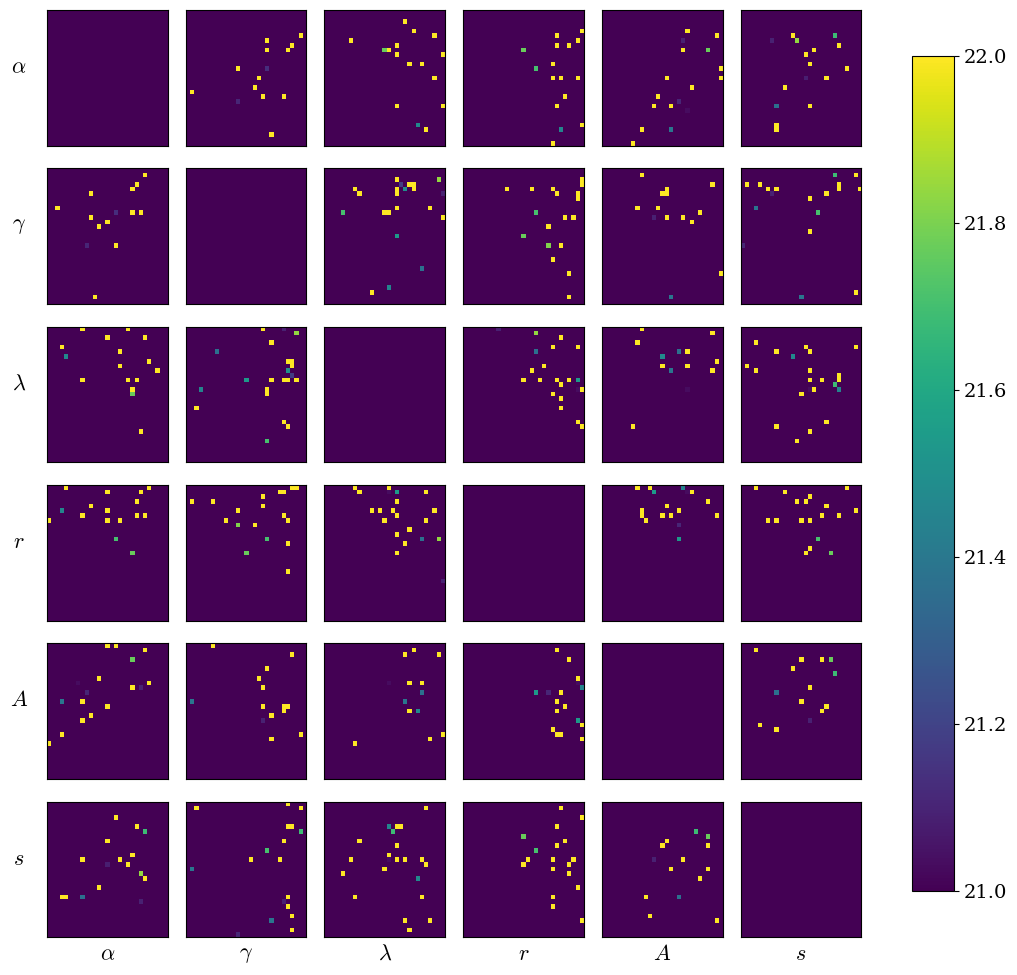

In [ ]:
param_names = [r"$\alpha$", r"$\gamma$", r"$\lambda$", r"$r$", r"$A$", r"$s$"]
bounds = list(PARAMETER_RANGES.values())
freq_lists = [d[-1] for d in data]

num_bins = 30

fig, axs = plt.subplots(len(param_names), len(param_names), figsize=(11,10))

for i in range(len(param_names)):
    pi_values = np.array([d[i] for d in data])
    pi_bounds = np.linspace(bounds[i][0], bounds[i][1], num_bins)
    for j in range(len(param_names)):
        pj_values = np.array([d[j] for d in data])
        pj_bounds = np.linspace(bounds[j][0], bounds[j][1], num_bins)
        heatmap = np.zeros((num_bins-1, num_bins-1))
        
        # Iterate over bins
        for a in range(num_bins-1):
            for b in range(num_bins-1):
                # Find indices that fall into this bin
                idxs = np.where(
                    (pi_values >= pi_bounds[a]) & (pi_values < pi_bounds[a+1]) &
                    (pj_values >= pj_bounds[b]) & (pj_values < pj_bounds[b+1])
                )[0]

                if len(idxs) > 0:
                    amplitudes = [freq_lists[k] for k in idxs]
                    if amplitudes:
                        combined = np.concatenate(amplitudes) 
                        combined[np.isnan(combined)] = 0
                        heatmap[a, b] = combined.mean()
                    else:
                        heatmap[a, b] = 0
                else:
                    heatmap[a, b] = 0

        im = axs[i][j].imshow(heatmap, origin="lower", aspect="auto", cmap="viridis", vmin=21, vmax=22)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        if j == 0:
            axs[i][j].set_ylabel(param_names[i], rotation=0, labelpad=20)
        if i == len(param_names)-1:
            axs[i][j].set_xlabel(param_names[j])

        last_im = im

fig.tight_layout()
fig.colorbar(last_im, ax=axs.ravel().tolist(), shrink=0.9)
plt.show()

### PT

In [ ]:
directory = "pt"
with open("../"+directory + "_dominant_frequencies_amplitudes.pickle", "rb") as f:
    freqs = pickle.load(f)

data = []
for idx,f in tqdm(enumerate(os.listdir("../"+directory))):
    with open(os.path.join("../"+directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = ((P["alpha"], P["rate"], P["A"], P["shock_size"], freqs[idx]["amplitudes"]))
    data.append(elem)

0it [00:00, ?it/s]

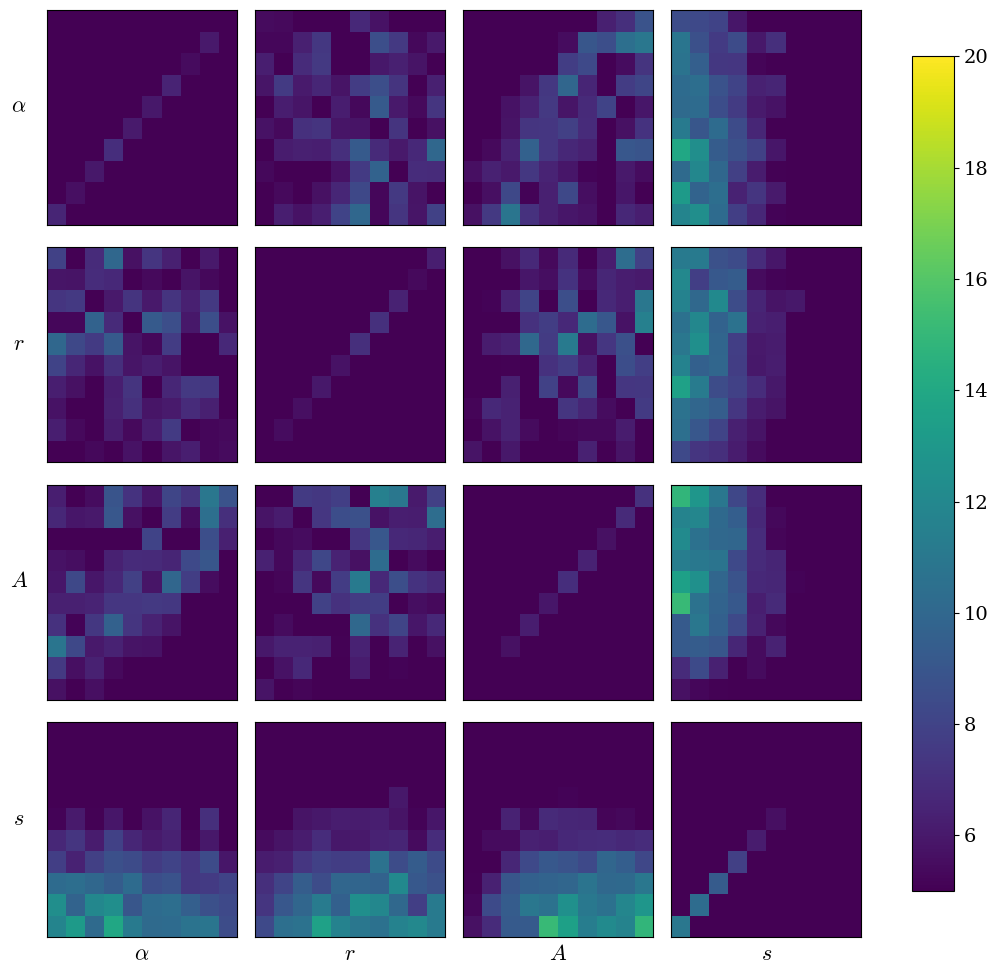

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(11,10))

param_names = [r"$\alpha$", r"$r$", r"$A$", r"$s$"]
bounds = list([PARAMETER_RANGES[k] for k in ["alpha", "rate", "A", "shock_size"]])
freq_lists = [d[-1] for d in data]

map_vals = []
for i in range(len(param_names)):
    pi_values = np.array([d[i] for d in data])
    pi_bounds = np.linspace(bounds[i][0], bounds[i][1], 11)
    for j in range(len(param_names)):
        pj_values = np.array([d[j] for d in data])
        pj_bounds = np.linspace(bounds[j][0], bounds[j][1], 11)
        heatmap = np.zeros((10, 10))

        # Iterate over bins
        for a in range(10):
            for b in range(10):
                # Find indices that fall into this bin
                idxs = np.where(
                    (pi_values >= pi_bounds[a]) & (pi_values < pi_bounds[a+1]) &
                    (pj_values >= pj_bounds[b]) & (pj_values < pj_bounds[b+1])
                )[0]

                if len(idxs) > 0:
                    amplitudes = [freq_lists[k] for k in idxs]
                    if amplitudes:
                        combined = np.concatenate(amplitudes) 
                        combined[np.isnan(combined)] = 0
                        heatmap[a, b] = combined.mean()
                    else:
                        heatmap[a,b] = 0
                else:
                    heatmap[a, b] = 0

        im = axs[i][j].imshow(heatmap, origin="lower", aspect="auto", cmap="viridis", vmin=5, vmax=20)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        if j == 0:
            axs[i][j].set_ylabel(param_names[i], rotation=0, labelpad=20)
        if i == len(param_names)-1:
            axs[i][j].set_xlabel(param_names[j])
        last_im = im

        map_vals.append(heatmap.flatten())

fig.tight_layout()
fig.colorbar(last_im, ax=axs.ravel().tolist(), shrink=0.9, norm="log")
plt.show()

# KDE of Dominant Amplitudes

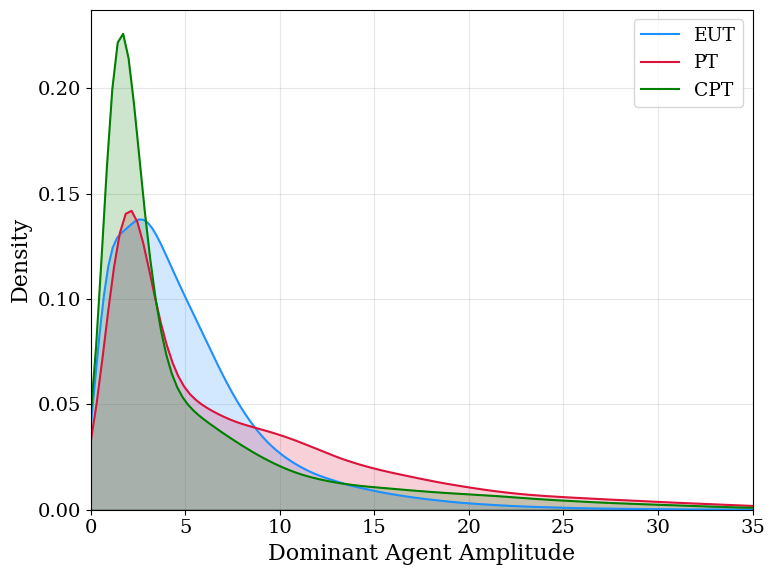

In [ ]:
labels = ["EUT", "PT", "CPT"]
colors = ["dodgerblue", "crimson", "green"]

for i, model in enumerate(["../eut", "../pt", "../cpt"]):
    with open(model + "_dominant_frequencies_amplitudes.pickle", "rb") as f:
        amplitudes = pickle.load(f)

    sims = [s["amplitudes"] for s in amplitudes]
    sims = np.concatenate(sims)
    sims = sims[~np.isnan(sims)]

    # compute KDE
    kde = gaussian_kde(sims, bw_method=0.1)

    # grid for x-values
    x_vals = np.linspace(min(sims), max(sims), 200)
    y_vals = kde(x_vals)

    y_vals /= np.trapz(y_vals, x_vals)
    plt.plot(x_vals, y_vals, color=colors[i], label=labels[i], lw=1.5)
    plt.fill_between(x_vals, y_vals, color=colors[i], alpha=0.2)

plt.xlabel("Dominant Agent Amplitude")
plt.ylabel("Density")
plt.legend()

max_x_tick = 35
plt.xlim(0, 35)
plt.xticks(np.linspace(0, 35, 8))

plt.ylim(0,)
plt.grid()
plt.tight_layout()
plt.savefig("../figures/agent_amplitude_kde.pdf", bbox_inches="tight")
plt.show()

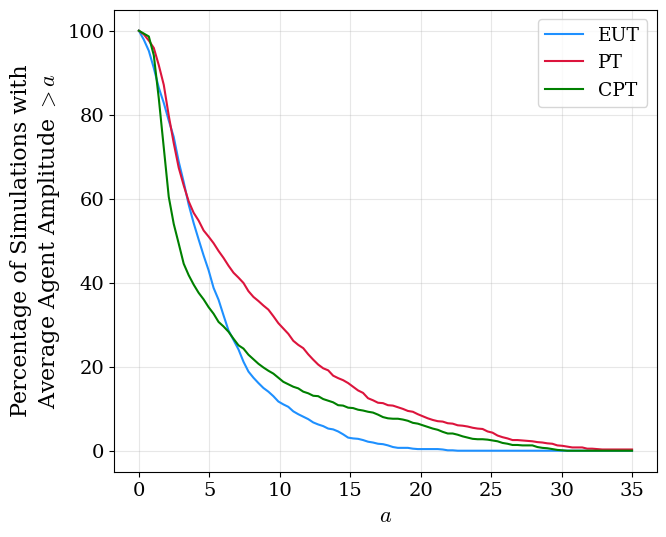

In [ ]:
plt.figure(figsize=(7,6))

cutoffs = np.linspace(0, 35, 100)
labels = ["EUT", "PT", "CPT"]
colors = ["dodgerblue", "crimson", "green"]
for i, model in enumerate(["eut", "pt", "cpt"]):
    with open("../"+model + "_dominant_frequencies_amplitudes.pickle", "rb") as f:
        amplitudes = pickle.load(f)
    count = []
    sims = [s["amplitudes"] for s in amplitudes]
    sims = np.concatenate(sims)
    sims = sims[~np.isnan(sims)]
    for mean_dominant_amplitude in cutoffs:
        subset = [x for x in amplitudes if np.mean(x["amplitudes"]) > mean_dominant_amplitude]
        count.append(100 * len(subset)/1024)
    plt.plot(cutoffs, count, label=labels[i], color=colors[i])

plt.legend()
plt.grid()
plt.ylabel("Percentage of Simulations with" + "\n"+ r"Average Agent Amplitude $> a$")
plt.xlabel(r"$a$")
plt.savefig("../figures/percent_simulations_amplitude.pdf", bbox_inches="tight")
plt.show()

# KS Distance

In [ ]:
with open("../cpt_dominant_frequencies_amplitudes.pickle", "rb") as f:
    amplitudes = pickle.load(f)
sims = [s["amplitudes"] for s in amplitudes]
sims = np.concatenate(sims)
sims = sims[~np.isnan(sims)]
cpt_sims = sims[sims >= significant_amplitude_thresold]

with open("../pt_dominant_frequencies_amplitudes.pickle", "rb") as f:
    amplitudes = pickle.load(f)
sims = [s["amplitudes"] for s in amplitudes]
sims = np.concatenate(sims)
sims = sims[~np.isnan(sims)]
pt_sims = sims[sims >= significant_amplitude_thresold]

ks_2samp(cpt_sims, pt_sims)

KstestResult(statistic=np.float64(0.2864936127061193), pvalue=np.float64(0.0), statistic_location=np.float64(16.680999963481057), statistic_sign=np.int8(-1))

In [ ]:
with open("../cpt_dominant_frequencies_amplitudes.pickle", "rb") as f:
    amplitudes = pickle.load(f)
cpt_sims = [s["amplitudes"] for s in amplitudes]

with open("../pt_dominant_frequencies_amplitudes.pickle", "rb") as f:
    amplitudes = pickle.load(f)
pt_sims = [s["amplitudes"] for s in amplitudes]

In [ ]:
ks_distance = []
for i in tqdm(range(len(cpt_sims))):
    cpt = cpt_sims[i]
    cpt = cpt[~np.isnan(cpt)]
    pt = pt_sims[i]
    pt = pt[~np.isnan(pt)]
    ks_distance.append(ks_2samp(cpt, pt)[0])

  0%|          | 0/1024 [00:00<?, ?it/s]

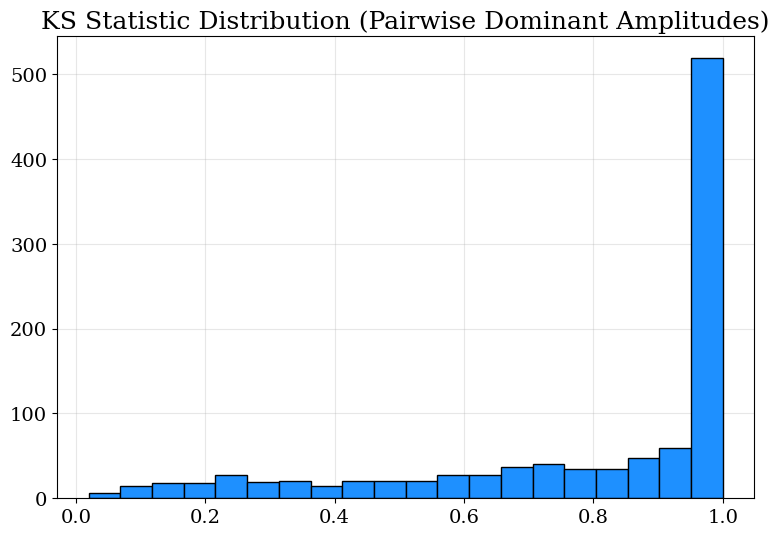

In [ ]:
plt.figure(figsize=(9,6))
plt.hist(ks_distance, color="dodgerblue", edgecolor="k", bins=20)
plt.title("KS Statistic Distribution (Pairwise Dominant Amplitudes)")
plt.grid()
plt.show()

In [ ]:
params = []
for idx,f in tqdm(enumerate(os.listdir("../cpt"))):
    with open(os.path.join("../cpt", f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = (P["alpha"], P["gamma"], P["lambda"], P["rate"], P["A"], P["shock_size"])
    params.append(elem)

0it [00:00, ?it/s]

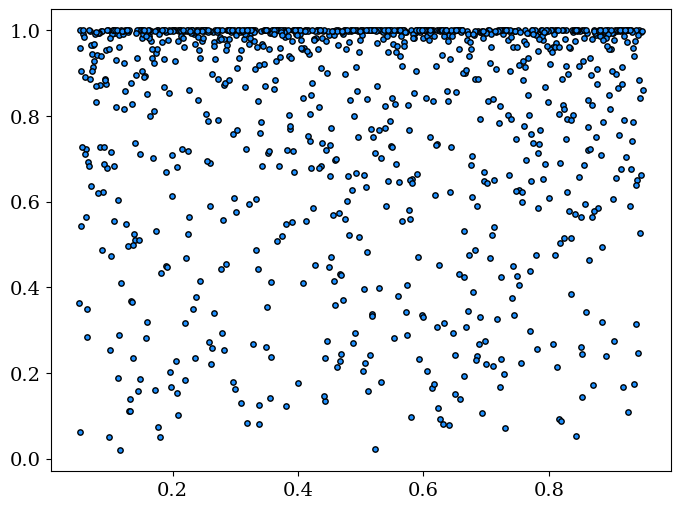

In [ ]:
plt.scatter(
    [p[4] for p in params],
    ks_distance,
    color="dodgerblue",
    edgecolor="k",
    s=15
)
plt.show()

# Heatmaps for Dominant Frequencies

### CPT

In [ ]:
directory = "cpt"

with open(directory + "_dominant_frequencies.pickle", "rb") as f:
    freqs = pickle.load(f)

data = []
for idx,f in tqdm(enumerate(os.listdir(directory))):
    with open(os.path.join(directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = ((P["alpha"], P["gamma"], P["omega"], P["eta"], P["P_H_increase"], P["P_H_decrease"], P["w_delta_scale"], freqs[idx]))
    data.append(elem)

FileNotFoundError: [Errno 2] No such file or directory: 'cpt_dominant_frequencies.pickle'

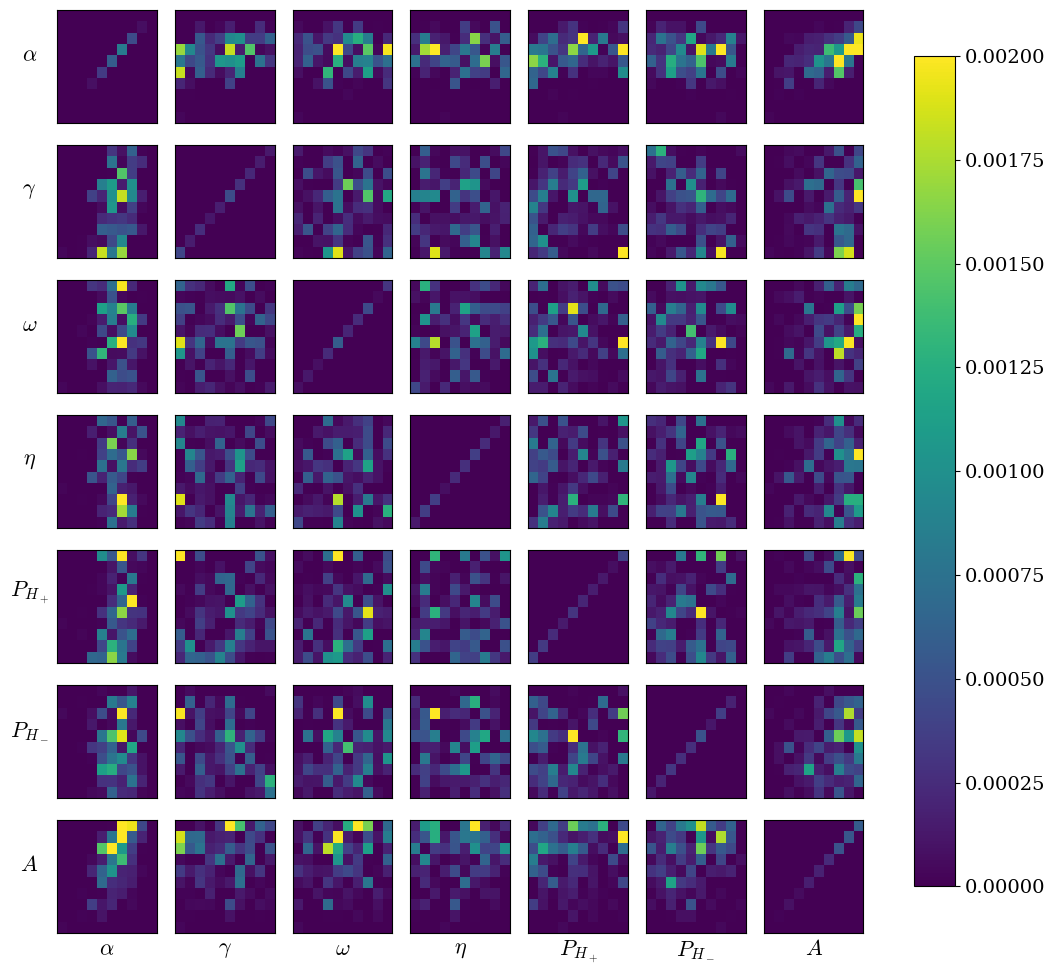

In [ ]:
fig, axs = plt.subplots(7, 7, figsize=(11,10))

param_names = [r"$\alpha$", r"$\gamma$", r"$\omega$", r"$\eta$", r"$P_{H_+}$",  r"$P_{H_-}$", r"$A$"]
bounds = [[0,1], [0.4,0.8], [1,4], [0.5, 1], [0,1], [0,1], [0,1]]
freq_lists = [d[-1] for d in data]

for i in range(7):
    pi_values = np.array([d[i] for d in data])
    pi_bounds = np.linspace(bounds[i][0], bounds[i][1], 11)
    for j in range(7):
        pj_values = np.array([d[j] for d in data])
        pj_bounds = np.linspace(bounds[j][0], bounds[j][1], 11)
        heatmap = np.zeros((10, 10))
        
        # Iterate over bins
        for a in range(10):
            for b in range(10):
                # Find indices that fall into this bin
                idxs = np.where(
                    (pi_values >= pi_bounds[a]) & (pi_values < pi_bounds[a+1]) &
                    (pj_values >= pj_bounds[b]) & (pj_values < pj_bounds[b+1])
                )[0]

                if len(idxs) > 0:
                    freq_lists_min_agents = [freq_lists[k] for k in idxs]
                    if freq_lists_min_agents:
                        combined_freqs = np.concatenate(freq_lists_min_agents) 
                        combined_freqs[np.isnan(combined_freqs)] = 0
                        heatmap[a, b] = combined_freqs.mean()
                    else:
                        heatmap[a,b] = 0
                else:
                    heatmap[a, b] = 0

        im = axs[i][j].imshow(heatmap, origin="lower", aspect="auto", cmap="viridis", vmin=0, vmax=0.002)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        if j == 0:
            axs[i][j].set_ylabel(param_names[i], rotation=0, labelpad=20)
        if i == 6:
            axs[i][j].set_xlabel(param_names[j])

        last_im = im

fig.tight_layout()
fig.colorbar(last_im, ax=axs.ravel().tolist(), shrink=0.9, norm="log")
plt.show()

### PT

In [ ]:
directory = "pt"

with open(directory + "_dominant_frequencies.pickle", "rb") as f:
    freqs = pickle.load(f)

data = []
for idx,f in tqdm(enumerate(os.listdir(directory))):
    with open(os.path.join(directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = ((P["alpha"], P["P_H_increase"], P["P_H_decrease"], P["w_delta_scale"], freqs[idx]))
    data.append(elem)

0it [00:00, ?it/s]

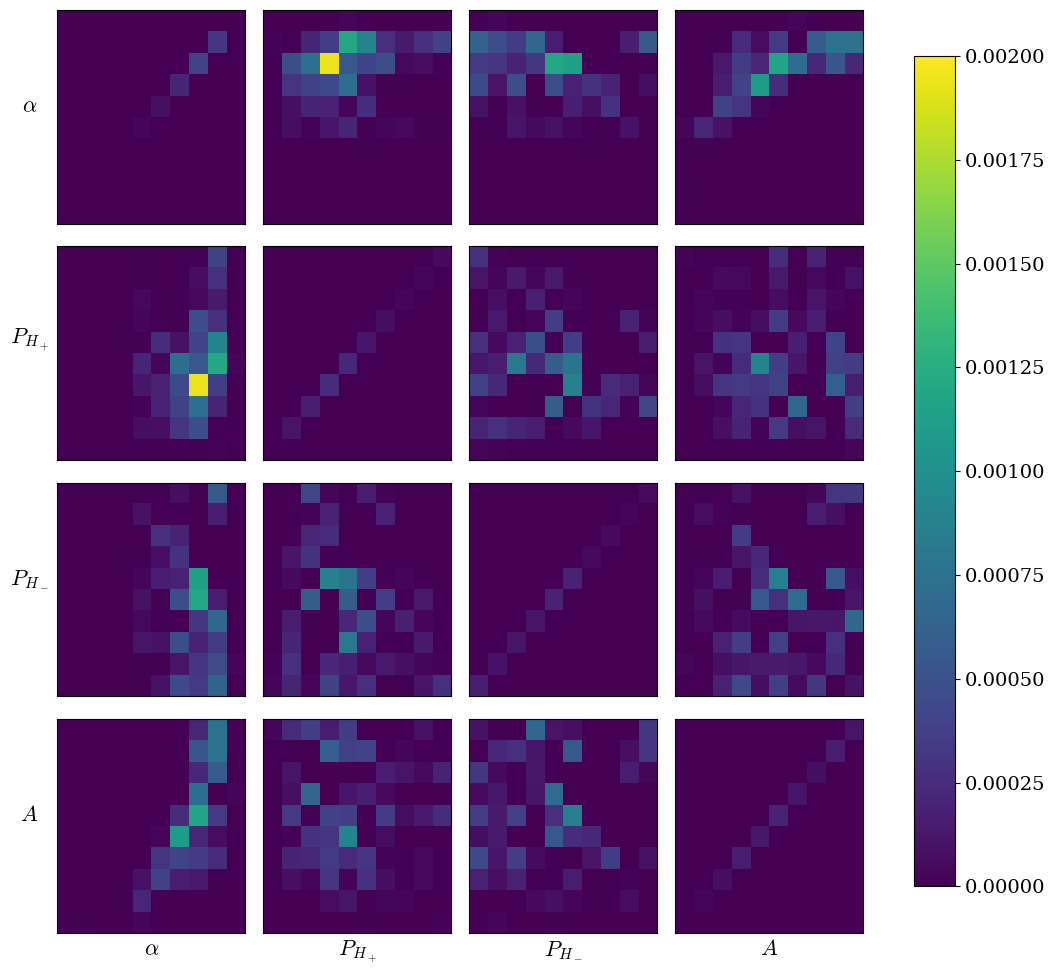

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(11,10))

param_names = [r"$\alpha$", r"$P_{H_+}$", r"$P_{H_-}$", r"$A$"]
bounds = [[0,1], [0,1], [0,1], [0,1]]
freq_lists = [d[-1] for d in data]

map_vals = []
for i in range(len(param_names)):
    pi_values = np.array([d[i] for d in data])
    pi_bounds = np.linspace(bounds[i][0], bounds[i][1], 11)
    for j in range(len(param_names)):
        pj_values = np.array([d[j] for d in data])
        pj_bounds = np.linspace(bounds[j][0], bounds[j][1], 11)
        heatmap = np.zeros((10, 10))

        # Iterate over bins
        for a in range(10):
            for b in range(10):
                # Find indices that fall into this bin
                idxs = np.where(
                    (pi_values >= pi_bounds[a]) & (pi_values < pi_bounds[a+1]) &
                    (pj_values >= pj_bounds[b]) & (pj_values < pj_bounds[b+1])
                )[0]

                if len(idxs) > 0:
                    freq_lists_min_agents = [freq_lists[k] for k in idxs]
                    if freq_lists_min_agents:
                        combined_freqs = np.concatenate(freq_lists_min_agents) 
                        combined_freqs[np.isnan(combined_freqs)] = 0
                        heatmap[a, b] = combined_freqs.mean()
                    else:
                        heatmap[a,b] = 0
                else:
                    heatmap[a, b] = 0

        im = axs[i][j].imshow(heatmap, origin="lower", aspect="auto", cmap="viridis", vmin=0, vmax=0.002)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        if j == 0:
            axs[i][j].set_ylabel(param_names[i], rotation=0, labelpad=20)
        if i == len(param_names)-1:
            axs[i][j].set_xlabel(param_names[j])
        last_im = im

        map_vals.append(heatmap.flatten())

fig.tight_layout()
fig.colorbar(last_im, ax=axs.ravel().tolist(), shrink=0.9, norm="log")
plt.show()

# Heatmaps for Oscillation Location

### CPT

In [ ]:
directory = "cpt"
cutoff = 1000

with open(directory + "_dominant_frequencies.pickle", "rb") as f:
    freqs = pickle.load(f)

oscillating_bool = [int(len(np.where(~np.isnan(s))[0]) >= cutoff) for s in freqs]

data = []
for idx,f in tqdm(enumerate(os.listdir(directory))):
    with open(os.path.join(directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = ((P["alpha"], P["gamma"], P["omega"], P["eta"], P["P_H_increase"], P["P_H_decrease"], P["w_delta_scale"], oscillating_bool[idx]))
    data.append(elem)

0it [00:00, ?it/s]

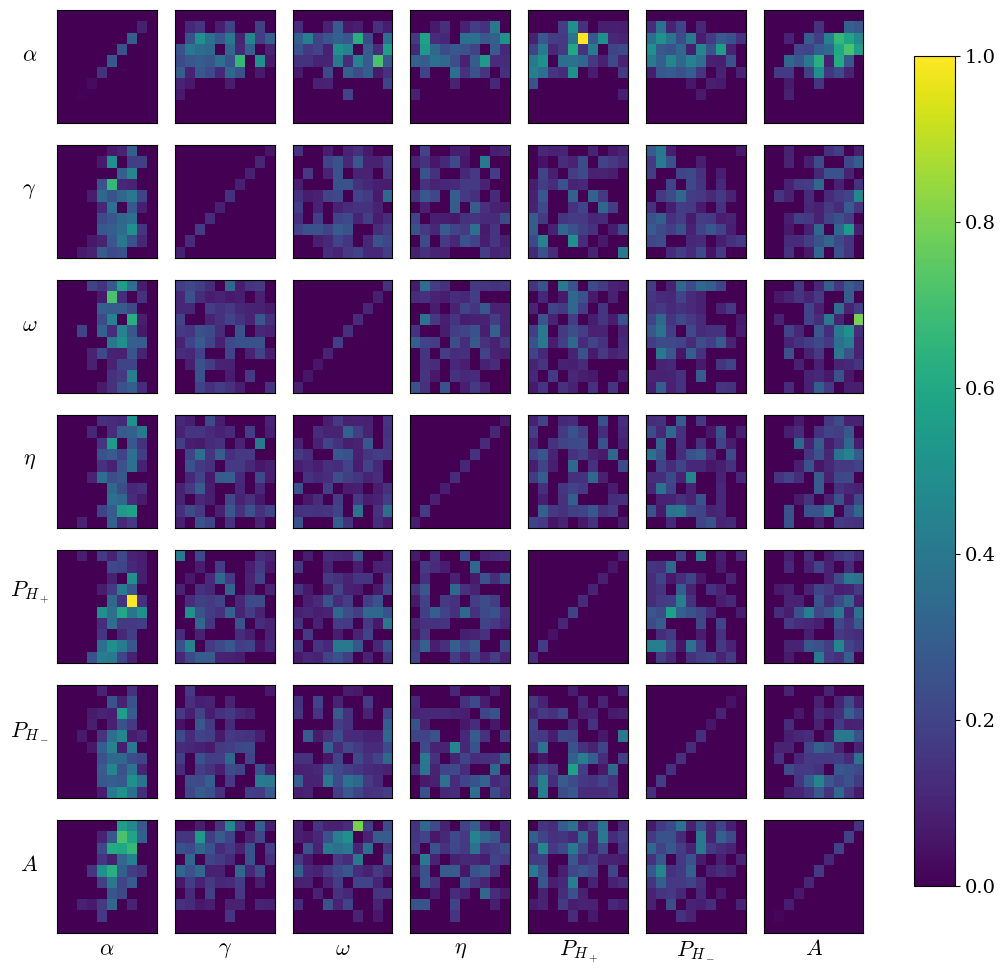

In [ ]:
fig, axs = plt.subplots(7, 7, figsize=(11,10))

param_names = [r"$\alpha$", r"$\gamma$", r"$\omega$", r"$\eta$", r"$P_{H_+}$",  r"$P_{H_-}$", r"$A$"]
bounds = [[0,1], [0.4,0.8], [1,4], [0.5, 1], [0,1], [0,1], [0,1]]
freq_lists = np.array([d[-1] for d in data])

for i in range(7):
    pi_values = np.array([d[i] for d in data])
    pi_bounds = np.linspace(bounds[i][0], bounds[i][1], 11)
    for j in range(7):
        pj_values = np.array([d[j] for d in data])
        pj_bounds = np.linspace(bounds[j][0], bounds[j][1], 11)
        heatmap = np.zeros((10, 10))
        
        # Iterate over bins
        for a in range(10):
            for b in range(10):
                # Find indices that fall into this bin
                idxs = np.where(
                    (pi_values >= pi_bounds[a]) & (pi_values < pi_bounds[a+1]) &
                    (pj_values >= pj_bounds[b]) & (pj_values < pj_bounds[b+1])
                )[0]
                
                # Concatenate all lists of freqs in this bin
                if len(idxs) > 0:
                    heatmap[a,b] = np.mean(freq_lists[idxs])
                else:
                    heatmap[a, b] = 0

        im = axs[i][j].imshow(heatmap, origin="lower", aspect="auto", cmap="viridis", vmin=0.0, vmax=1.0)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        if j == 0:
            axs[i][j].set_ylabel(param_names[i], rotation=0, labelpad=20)
        if i == 6:
            axs[i][j].set_xlabel(param_names[j])

        last_im = im

fig.tight_layout()
fig.colorbar(last_im, ax=axs.ravel().tolist(), shrink=0.9, norm="log")
plt.show()

### PT

In [ ]:
directory = "pt"
cutoff = 1000

with open(directory + "_dominant_frequencies.pickle", "rb") as f:
    freqs = pickle.load(f)

oscillating_bool = [int(len(np.where(~np.isnan(s))[0]) >= cutoff) for s in freqs]

data = []
for idx,f in tqdm(enumerate(os.listdir(directory))):
    with open(os.path.join(directory, f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = ((P["alpha"], P["P_H_increase"], P["P_H_decrease"], P["w_delta_scale"], oscillating_bool[idx]))
    data.append(elem)

0it [00:00, ?it/s]

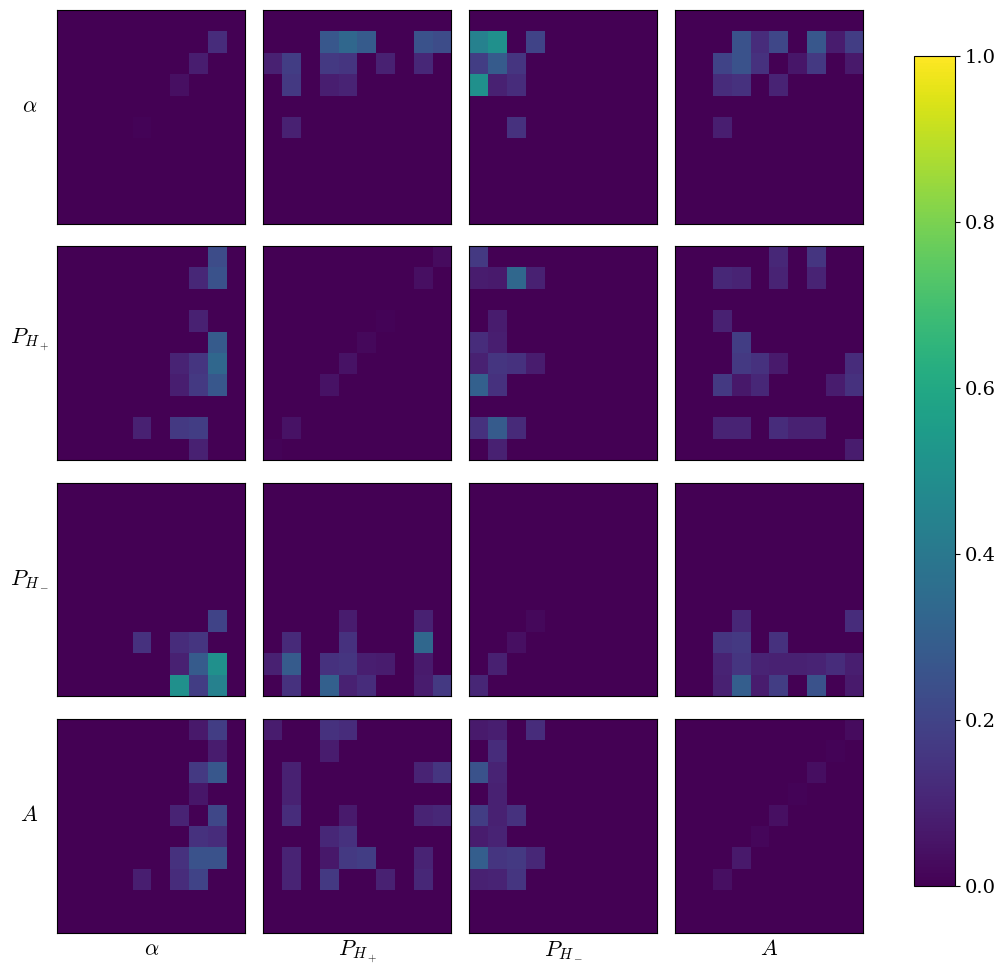

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(11,10))

param_names = [r"$\alpha$", r"$P_{H_+}$", r"$P_{H_-}$", r"$A$"]
bounds = [[0,1], [0,1], [0,1], [0,1]]
freq_lists = np.array([d[-1] for d in data])

map_vals = []
for i in range(len(param_names)):
    pi_values = np.array([d[i] for d in data])
    pi_bounds = np.linspace(bounds[i][0], bounds[i][1], 11)
    for j in range(len(param_names)):
        pj_values = np.array([d[j] for d in data])
        pj_bounds = np.linspace(bounds[j][0], bounds[j][1], 11)
        heatmap = np.zeros((10, 10))

        # Iterate over bins
        for a in range(10):
            for b in range(10):
                # Find indices that fall into this bin
                idxs = np.where(
                    (pi_values >= pi_bounds[a]) & (pi_values < pi_bounds[a+1]) &
                    (pj_values >= pj_bounds[b]) & (pj_values < pj_bounds[b+1])
                )[0]

                # Concatenate all lists of freqs in this bin
                if len(idxs) > 0:
                    heatmap[a,b] = np.mean(freq_lists[idxs])
                else:
                    heatmap[a, b] = 0

        im = axs[i][j].imshow(heatmap, origin="lower", aspect="auto", cmap="viridis", vmin=0.0, vmax=1.0)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        if j == 0:
            axs[i][j].set_ylabel(param_names[i], rotation=0, labelpad=20)
        if i == len(param_names)-1:
            axs[i][j].set_xlabel(param_names[j])
        last_im = im

        map_vals.append(heatmap.flatten())

fig.tight_layout()
fig.colorbar(last_im, ax=axs.ravel().tolist(), shrink=0.9, norm="log")
plt.show()

# KDE of Dominant Freqs

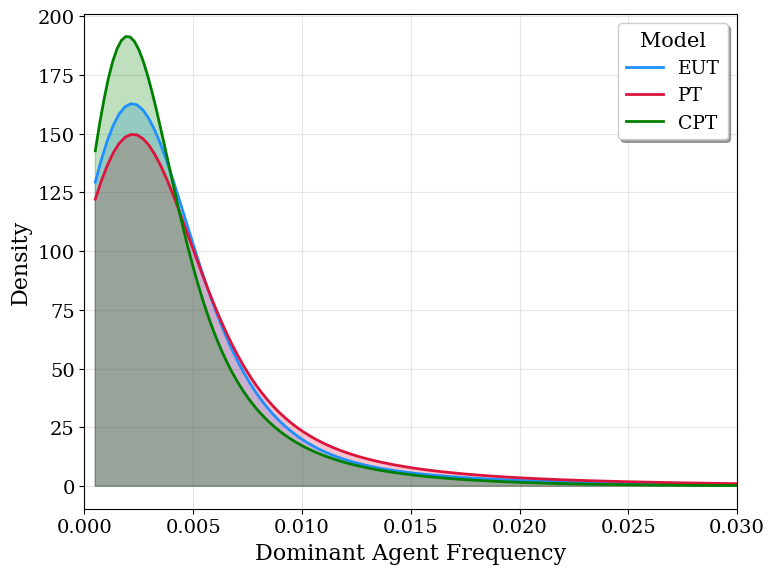

In [ ]:
labels = ["EUT", "PT", "CPT"]
colors = ["dodgerblue", "crimson", 'green']

for i, directory in enumerate(["../eut", "../pt", "../cpt"]):
    with open(directory + "_dominant_frequencies_amplitudes.pickle", "rb") as f:
        data = pickle.load(f)

    sims = [s["frequencies"] for s in data]
    sims = np.concatenate(sims)
    sims = sims[~np.isnan(sims)]

    # compute KDE
    kde = gaussian_kde(sims, bw_method=0.4)

    # grid for x-values
    x_vals = np.linspace(min(sims), max(sims), 500)
    y_vals = kde(x_vals)

    # normalize so area = 1 (proportion density)
    y_vals /= np.trapz(y_vals, x_vals)
    plt.plot(x_vals, y_vals, color=colors[i], label=labels[i], lw=2)
    plt.fill_between(x_vals, y_vals, color=colors[i], alpha=0.25)

plt.xlabel("Dominant Agent Frequency")
plt.ylabel("Density")
plt.legend(shadow=True, title="Model")
plt.grid()
plt.xlim(0,0.03)
plt.tight_layout()
plt.show()

# Radar Plots for Param Values

In [ ]:
def load_data(directory):
    with open(f"../{directory}_dominant_frequencies_amplitudes.pickle", "rb") as f:
        freqs = pickle.load(f)
    y = np.array([np.mean(f["amplitudes"])for f in freqs])

    parameters = []
    for f_name in tqdm(os.listdir(f"../{directory}")):
        if f_name.endswith('.pickle'):
            with open(os.path.join(f"../{directory}", f_name), "rb") as f:
                P = pickle.load(f)["params"]
            # Different parameter sets for CPT vs PT
            if directory == "cpt":
                elem = (P["alpha"], P["gamma"], P["lambda"], P["rate"], P["A"], P["shock_size"])
            elif directory == "pt":
                elem = (P["alpha"], P["lambda"], P["rate"], P["A"], P["shock_size"])
            else:
                elem = (P["alpha"], P["rate"], P["A"], P["shock_size"])
            parameters.append(elem)
    return np.array(parameters), y

# Load data
cpt_P, cpt_y = load_data("cpt")
pt_P, pt_y = load_data("pt")
# eut_P, eut_y = load_data("eut")

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

In [ ]:
def prepare_radar_data(params, y, threshold):
    """Compute normalized average values and radar angles for plotting."""
    # Min-max normalization per dataset
    baseline = params[y<threshold]
    avg_baseline = np.mean(baseline, axis=0)
    min_vals_baseline = np.min(baseline, axis=0)
    max_vals_baseline = np.max(baseline, axis=0)
    normalized_avg_baseline = (avg_baseline - min_vals_baseline) / (max_vals_baseline - min_vals_baseline)

    significant = params[y>=threshold]
    print(len(significant)/1024)
    avg_significant = np.mean(significant, axis=0)
    min_vals_significant = np.min(baseline, axis=0)
    max_vals_significant = np.max(baseline, axis=0)
    normalized_avg_significant = (avg_significant - min_vals_significant) / (max_vals_significant - min_vals_significant)

    # Compute angles for radar plot
    num_vars = params.shape[1]
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Close the radar plot
    normalized_avg_baseline = np.concatenate((normalized_avg_baseline, [normalized_avg_baseline[0]]))
    normalized_avg_significant = np.concatenate((normalized_avg_significant, [normalized_avg_significant[0]]))
    angles += angles[:1]

    return normalized_avg_baseline, normalized_avg_significant, angles

# Prepare radar data
cpt_baseline, cpt_significant, cpt_angles = prepare_radar_data(cpt_P, cpt_y, threshold=20)
pt_baseline, pt_significant, pt_angles = prepare_radar_data(pt_P, pt_y, threshold=20)

0.0625
0.083984375


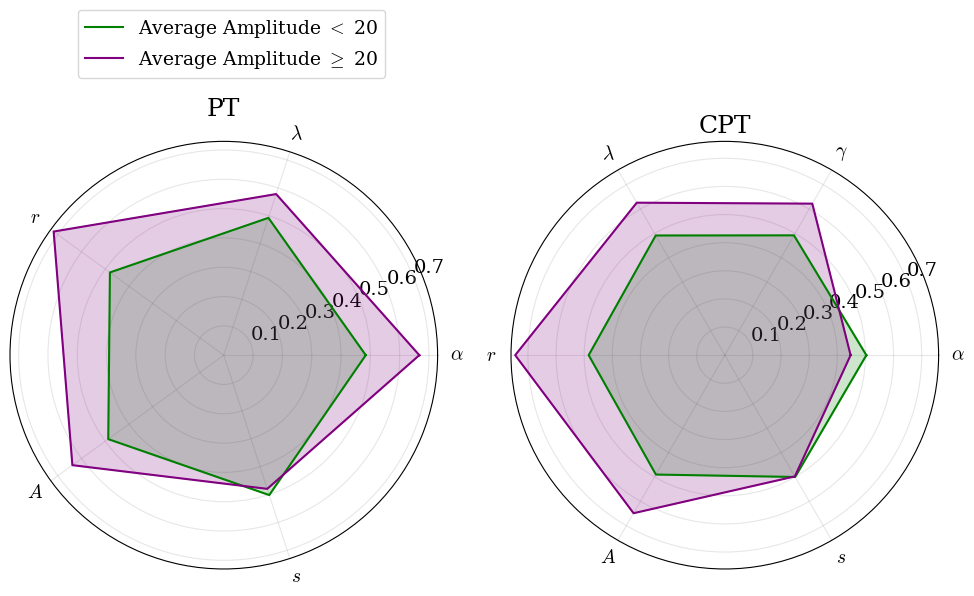

In [89]:
def plot_radar_chart(ax, angles, data_baseline, data_significant, labels, title, legend=True):
    """Helper function to plot a single radar chart."""
    ax.plot(angles, data_baseline, color="green", linewidth=1.5, linestyle='solid', label=r'Average Amplitude $<$ 20')
    ax.fill(angles, data_baseline, color="green", alpha=0.2)
    ax.plot(angles, data_significant, color="purple", linewidth=1.5, linestyle='solid', label=r'Average Amplitude $\geq$ 20')
    ax.fill(angles, data_significant, color="purple", alpha=0.2)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_title(title)
    if legend:
        ax.legend(bbox_to_anchor=(0.9, 1.33))

# Plot side-by-side radar charts
fig, axs = plt.subplots(1, 2, figsize=(10, 8), subplot_kw=dict(polar=True))

pt_labels = [r"$\alpha$", r"$\lambda$",  r"$r$", r"$A$", r"$s$"]
plot_radar_chart(axs[0], pt_angles, pt_baseline, pt_significant, pt_labels, "PT", legend=True)

cpt_labels = [r"$\alpha$", r"$\gamma$", r"$\lambda$", r"$r$", r"$A$", r"$s$"]
plot_radar_chart(axs[1], cpt_angles, cpt_baseline, cpt_significant, cpt_labels, "CPT", legend=False)

plt.tight_layout()
plt.savefig("../figures/amplitude_radars.pdf", bbox_inches="tight")
plt.show()

# Large Mean Amplitude Simulations

In [ ]:
params = {k:[] for k in PARAMETER_RANGES}
for f_name in tqdm(os.listdir(f"../cpt")):
    with open(os.path.join(f"../cpt", f_name), "rb") as f:
        P = pickle.load(f)["params"]
    for k in PARAMETER_RANGES:
        params[k].append(P[k])

  0%|          | 0/1024 [00:00<?, ?it/s]

In [ ]:
threshold = 20
with open("../cpt_dominant_frequencies_amplitudes.pickle", "rb") as f:
    data = pickle.load(f)
sims = [int(np.mean(f["amplitudes"]) >= threshold) for f in data]

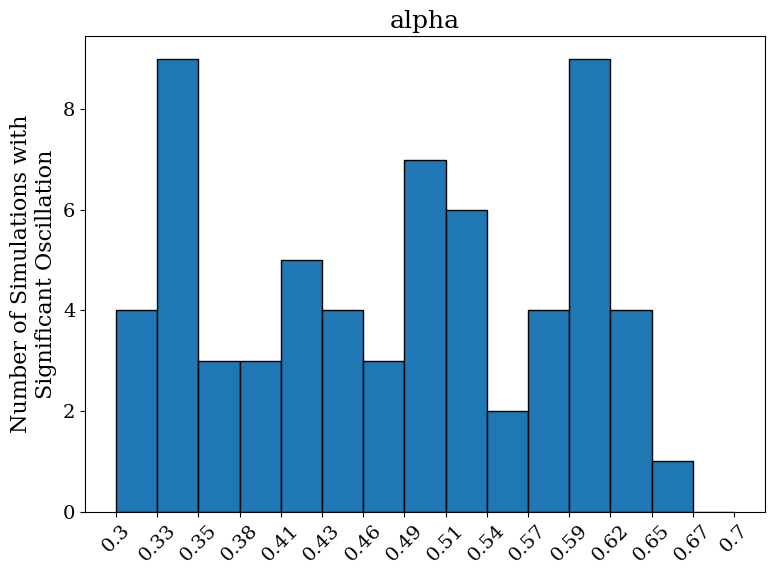

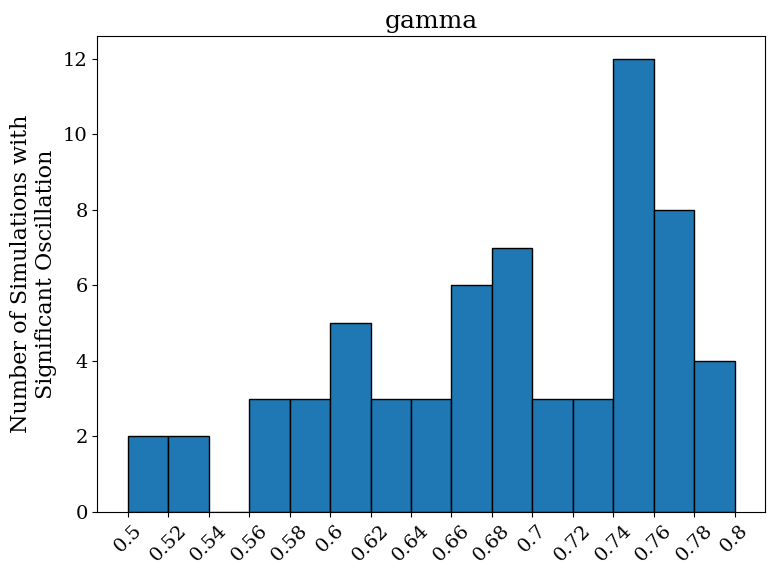

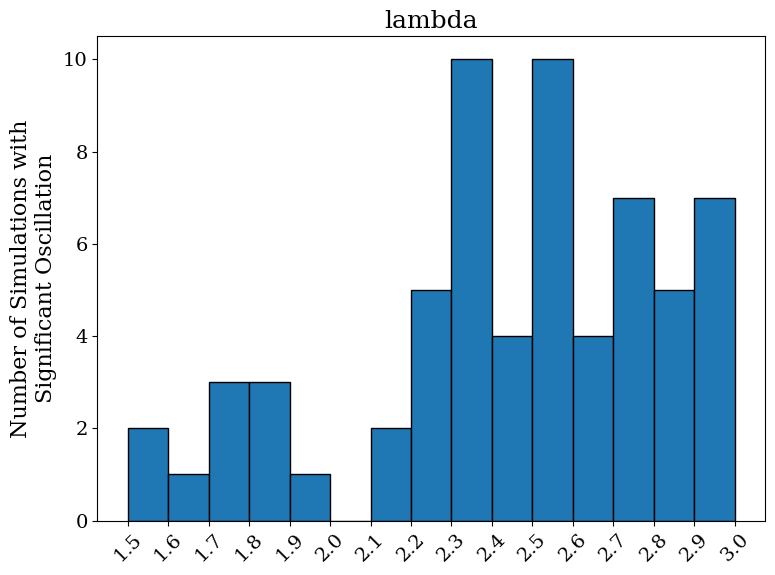

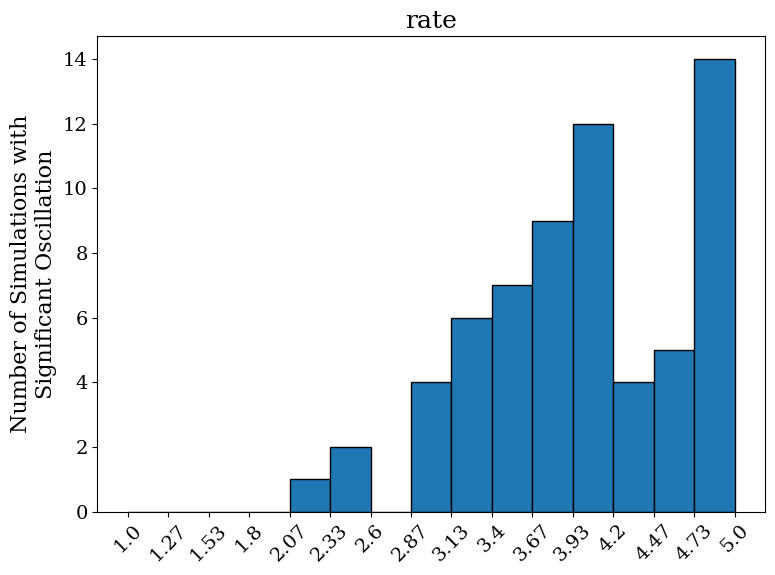

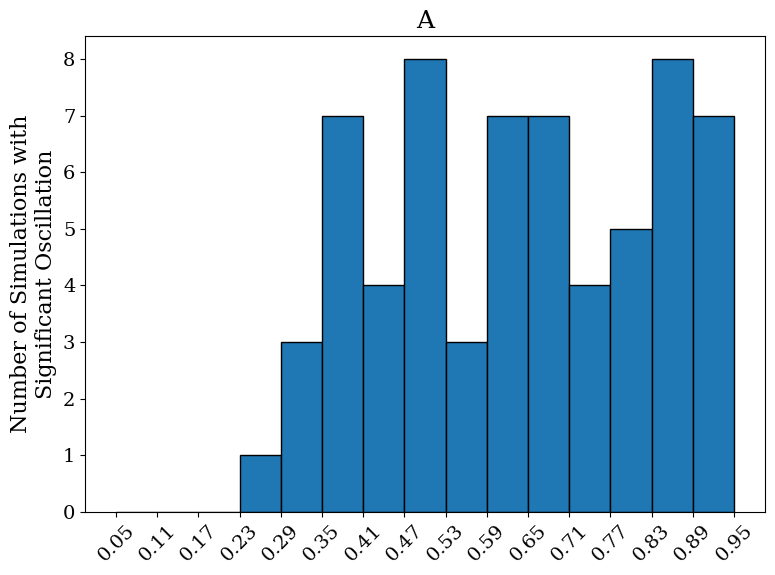

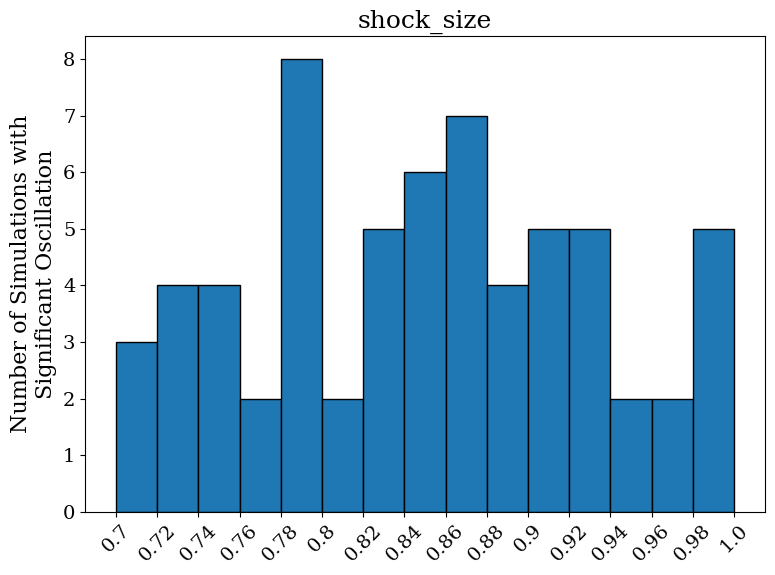

In [ ]:
N = 16
for p, interval in PARAMETER_RANGES.items():
    edges = np.linspace(interval[0], interval[1], N)
    centers = 0.5 * (edges[:-1] + edges[1:])
    high_amplitude_sims = np.zeros(N-1)
    for k in range(1, N):
        for j, val in enumerate(params[p]):
            if edges[k-1] < val <= edges[k] and sims[j]:
                high_amplitude_sims[k-1] += 1

    plt.bar(
        centers,
        high_amplitude_sims,
        width=(edges[1] - edges[0]),
        align="center",
        edgecolor="k"
    )
    plt.xticks(edges, np.round(edges, 2), rotation=45)
    plt.title(p)
    plt.ylabel("Number of Simulations with\nSignificant Oscillation")
    plt.tight_layout()
    plt.show()  

# Probability of Large Cycle Given Parameter Values?

In [ ]:
params = []
for idx,f in tqdm(enumerate(os.listdir("../cpt"))):
    with open(os.path.join("../cpt", f), "rb") as f:
        P = pickle.load(f)["params"]
    elem = (P["alpha"], P["gamma"], P["lambda"], P["rate"], P["A"], P["shock_size"])
    params.append(elem)

0it [00:00, ?it/s]

In [ ]:
with open("../cpt_dominant_frequencies_amplitudes.pickle", "rb") as f:
    data = pickle.load(f)

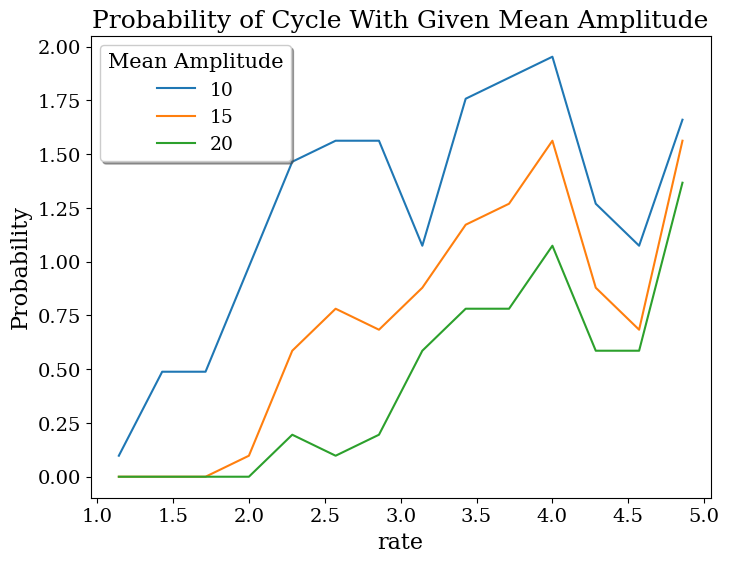

In [ ]:
N = 15
idx = 3

parameter = list(PARAMETER_RANGES.keys())[idx]
edges = np.linspace(PARAMETER_RANGES[parameter][0], PARAMETER_RANGES[parameter][1], N)
centers = 0.5 * (edges[:-1] + edges[1:])

for T in [10, 15, 20]:
    sims = [int(np.mean(f["amplitudes"]) >= T) for f in data]
    high_amplitude_sims = np.zeros(N-1)
    all_sims = np.zeros(N-1)
    for k in range(1, N):
        for j, val in enumerate([p[idx] for p in params]):
            all_sims[k-1] += 1
            if edges[k-1] < val <= edges[k] and sims[j]:
                high_amplitude_sims[k-1] += 1
    
    plt.plot(centers, 100*(high_amplitude_sims/all_sims), label=T)

plt.legend(title="Mean Amplitude", shadow=True)
plt.title("Probability of Cycle With Given Mean Amplitude")
plt.ylabel("Probability")
plt.xlabel(parameter)
plt.show()

# Visualize Large Amplitude Cycles

  0%|          | 0/1024 [00:00<?, ?it/s]

{'N': 200, 'alpha': np.float64(0.4815332714645488), 'gamma': np.float64(0.7083340163392075), 'lambda': np.float64(2.4196470795674716), 'eta': 0.88, 'P_H_increase': 0.95, 'P_H_decrease': 0.05, 'rate': np.float64(3.0231062047217354), 'A': np.float64(0.4733322907766688), 'theta': 0.88, 'beta': 0.95, 'P_health_catastrophe': 0.01, 'shock_size': np.float64(0.8571139729059644)}


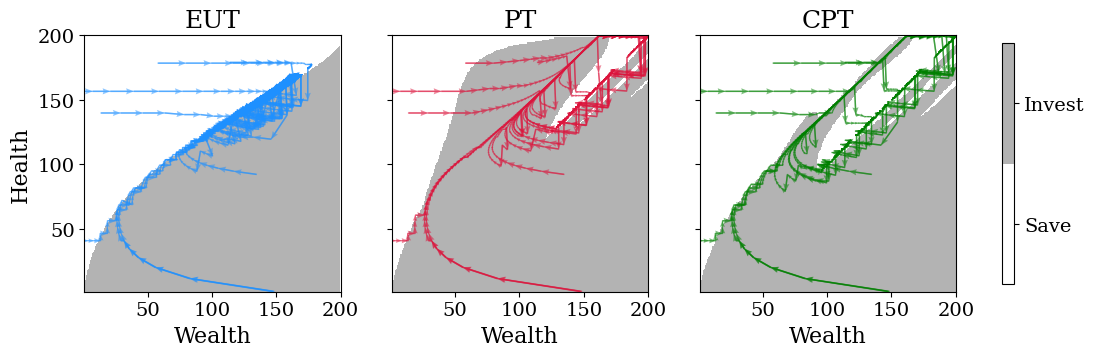

In [61]:
directory = "cpt"

with open("../"+directory + "_dominant_frequencies_amplitudes.pickle", "rb") as f:
    freqs = pickle.load(f)
sims = [int(np.mean(f["amplitudes"]) >= 20) for f in freqs]

def plot_trajectories(ax, res, color, indices):
    """
    Helper function to plot random agent trajectories with arrows.
    """
    for i in indices:
        w_path = unpack_and_dequantize(res["wealth"][i, :500], 200)
        h_path = unpack_and_dequantize(res["health"][i, :500], 200)
        ax.plot(w_path, h_path, color=color, alpha=0.5, linewidth=1)
        x = w_path[:-1]
        y = h_path[:-1]
        u = np.diff(w_path)
        v = np.diff(h_path)
        ax.quiver(x, y, u, v, color=color, alpha=0.5, 
                  angles='xy', scale_units='xy', scale=1, 
                  width=0.006, headwidth=4, headlength=5)

for idx, f_name in enumerate(tqdm(os.listdir("../"+directory))):
    if sims[idx]:

        # Define a discrete binary colormap for consistency across plots
        # This divides the 'Greys' map into exactly 2 colors
        binary_cmap = plt.cm.get_cmap('Greys', 2)

        # --- CPT ---
        with open(os.path.join("../"+directory, f_name), "rb") as f:
            res = pickle.load(f)
        P = res["params"]
        if P["alpha"] != 0.4815332714645488:
            continue
        print(P)
        fig, axs = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
        axs[2].imshow(res["policy"].T, origin="lower", cmap=binary_cmap, alpha=0.3)

        w_start = res["wealth"][:, 0]
        h_start = res["health"][:, 0]

        # Determine midpoint based on data range (handles normalized 0-1 or integer 0-200)
        # We assume the plot limits (200) represent the full scale.
        data_max = np.max(w_start)
        mid = 100 if data_max > 1 else 0.5

        # Define masks for the 4 quadrants (Cartesian plane logic)
        # Q1: Top-Right (High Wealth, High Health)
        # Q2: Top-Left (Low Wealth, High Health)
        # Q3: Bottom-Left (Low Wealth, Low Health)
        # Q4: Bottom-Right (High Wealth, Low Health)
        quadrants = [
            (w_start >= mid) & (h_start >= mid), # Q1
            (w_start < mid) & (h_start >= mid),  # Q2
            (w_start < mid) & (h_start < mid),   # Q3
            (w_start >= mid) & (h_start < mid)   # Q4
        ]
        indices = []
        for mask in quadrants:
            candidates = np.where(mask)[0]
            if len(candidates) >= 2:
                picked = np.random.choice(candidates, 2, replace=False)
            else:
                picked = candidates
            indices.extend(picked)
        indices = np.array(indices)
        
        # Check if we found enough; if grid is sparse, fill remaining spots randomly
        if len(indices) < 8:
            remaining_needed = 8 - len(indices)
            all_indices = np.arange(res["wealth"].shape[0])
            # Exclude already picked
            available = np.setdiff1d(all_indices, indices)
            fillers = np.random.choice(available, remaining_needed, replace=False)
            indices = np.concatenate([indices, fillers])
        
        plot_trajectories(axs[2], res, "green", indices)
        axs[2].set_xlim(1, 200)
        axs[2].set_ylim(1, 200)
        axs[2].set_title("CPT")
        axs[2].set_xlabel("Wealth")

        # --- PT ---
        pt_f = f"{P['alpha']}_1.0_{P["lambda"]}_{P['rate']}_{P['A']}_{P['shock_size']}.pickle"
        with open(os.path.join("../pt", pt_f), "rb") as f:
            res = pickle.load(f)
            
        axs[1].imshow(res["policy"].T, origin="lower", cmap=binary_cmap, alpha=0.3)
        plot_trajectories(axs[1], res, "crimson", indices)
        axs[1].set_xlim(1, 200)
        axs[1].set_ylim(1, 200)
        axs[1].set_title("PT")
        axs[1].set_xlabel("Wealth")

        # --- EUT ---
        eut_f = f"{P['alpha']}_1.0_1.0_{P['rate']}_{P['A']}_{P['shock_size']}.pickle"
        with open(os.path.join("../eut", eut_f), "rb") as f:
            res = pickle.load(f)
            
        # Capture the image object (im) to pass to colorbar
        im = axs[0].imshow(res["policy"].T, origin="lower", cmap=binary_cmap, alpha=0.3, vmin=0, vmax=1)
        plot_trajectories(axs[0], res, "dodgerblue", indices)
        axs[0].set_xlim(1, 200)
        axs[0].set_ylim(1, 200)
        axs[0].set_title("EUT")
        axs[0].set_xlabel("Wealth")
        axs[0].set_ylabel("Health")

        cbar = fig.colorbar(im, ax=axs, location='right', ticks=[0.25, 0.75], fraction=0.013)
        cbar.ax.set_yticklabels(['Save', 'Invest'])
        plt.savefig("../figures/policy_trajectories_cycle.pdf", bbox_inches="tight")
        plt.show()
        break